The Goal is to make an Image Classifier that works on any DataSet (Virtually)

# Starting with the Project
____

# Importing Required Libraries

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import cv2
import imghdr

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

from tensorflow.keras.models import load_model

import os

### *Setting up and Checking some Dependencies*

In [2]:
cpus = tf.config.experimental.list_physical_devices('CPU')
print("No. of CPU available = ", len(cpus))
print(cpus)

gpus = tf.config.experimental.list_physical_devices('GPU')
print("\nNo. of GPU available = ", len(gpus))
print(gpus)

No. of CPU available =  1
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

No. of GPU available =  0
[]


Out of memory (OOM) is an often undesired state of computer operation where no additional memory can be allocated for use by programs or the operating system.

# Loading the Data and Preprocessing

### *Removing dodgy images* 
Images that are or might be corrupted or with errors (like wrong extension etc)

In [3]:
# loading the Data Directory
data_dir = 'data'

In [4]:
# Checking the Contents of Data Directory
os.listdir(data_dir)

['happy_people', 'sad_people']

In [5]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [6]:
# Removing unwanted (dodgy) Image Types

for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

### *Loading the Dataset*

In [7]:
# Loading the Data
data = tf.keras.utils.image_dataset_from_directory('data')

Found 151 files belonging to 2 classes.


In [8]:
# as_numpy_iterator() will preserve the nested structure of dataset elements.
data_iterator = data.as_numpy_iterator()

In [9]:
# if we run it again it will give another batch of data
batch = data_iterator.next()

In [10]:
print(data_iterator)
print(len(batch))
print(batch[0])

2
[[[[247.        247.        247.       ]
   [247.        247.        247.       ]
   [247.        247.        247.       ]
   ...
   [ 67.17163    42.17163    22.17163  ]
   [ 88.212006   63.212006   43.212006 ]
   [ 88.914276   67.914276   46.914276 ]]

  [[247.        247.        247.       ]
   [247.        247.        247.       ]
   [247.        247.        247.       ]
   ...
   [107.80505    82.80505    62.805054 ]
   [ 80.22592    55.22592    35.22592  ]
   [ 83.58942    61.589417   40.589417 ]]

  [[247.        247.        247.       ]
   [247.        247.        247.       ]
   [247.        247.        247.       ]
   ...
   [ 80.44675    55.446747   35.446747 ]
   [ 73.39987    48.39987    28.399872 ]
   [ 78.35156    51.898438   32.625    ]]

  ...

  [[162.04593   160.04593   171.04593  ]
   [163.13779   161.13779   172.13779  ]
   [164.6102    164.6102    174.6102   ]
   ...
   [125.16016    86.16016    71.16016  ]
   [126.5831     87.5831     72.5831   ]
   [130.1514  

In [11]:
# Image Represented as Numpy array
batch[0].shape

(32, 256, 256, 3)

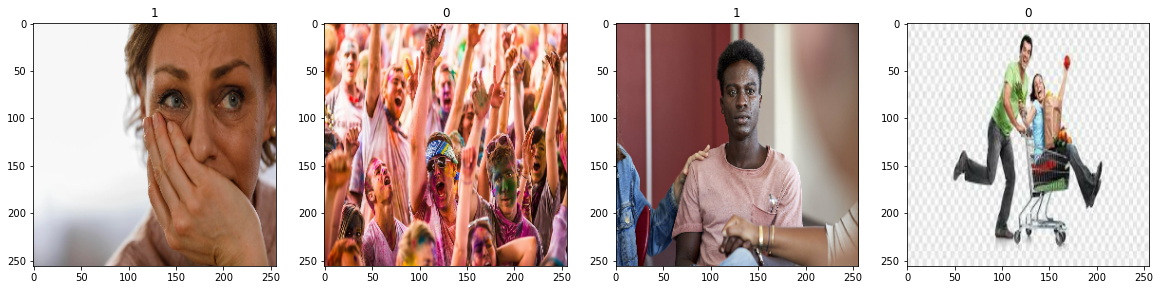

In [12]:
# plotting 4 images at a Time (ncols=4)
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

Here we Observe that :

0 = Happy People

1 = Sad People

### *Scaling the Data*

In [13]:
print("Min value in batch[0] = ",batch[0].min())
print("Max value in batch[0] = ",batch[0].max())

Min value in batch[0] =  0.0
Max value in batch[0] =  255.0


 Map in Python is a function that works as an iterator to return a result 
 after applying a function to every item of an iterable (tuple, lists, etc.). 
 It is used when you want to apply a single transformation function to all the iterable elements. 
 The iterable and function are passed as arguments to the map in Python.
 
 A lambda expression is a way of creating a little function inline, without all the syntax of a def. 
 Here is a lambda with a single n parameter, returning the parameter value doubled.

In [14]:
data = data.map(lambda x,y: (x/255, y))

In [15]:
# Scaled data (batch)
data.as_numpy_iterator().next()[0]

array([[[[1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         ...,
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ]],

        [[1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         ...,
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ]],

        [[1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         ...,
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ]],

        ...,

        [[1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ]

### *Splitting the DataSet*

In [16]:
# length of data (ie, no. of batches)
len(data)

5

In [17]:
# splitting into 70%train, 20%validation, 10%test

train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1 +1)

train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [18]:
train

<TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [19]:
val

<TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [20]:
test

<TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

# Creating the Deep Learning (CNN) Model

In [21]:
model = Sequential()

In [22]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [23]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

### *Training the Model*

In [25]:
# having a log directory for checkpoints and recovery
logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [26]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
3/3 [==============================] - 8s 2s/step - loss: 1.5004 - accuracy: 0.4688 - val_loss: 2.5138 - val_accuracy: 0.4062
Epoch 2/20
3/3 [==============================] - 6s 2s/step - loss: 1.5135 - accuracy: 0.4167 - val_loss: 0.6278 - val_accuracy: 0.7500
Epoch 3/20
3/3 [==============================] - 6s 2s/step - loss: 0.6138 - accuracy: 0.6667 - val_loss: 0.6848 - val_accuracy: 0.5312
Epoch 4/20
3/3 [==============================] - 6s 2s/step - loss: 0.5417 - accuracy: 0.6562 - val_loss: 0.5808 - val_accuracy: 0.6562
Epoch 5/20
3/3 [==============================] - 6s 2s/step - loss: 0.6167 - accuracy: 0.6354 - val_loss: 0.5979 - val_accuracy: 0.8125
Epoch 6/20
3/3 [==============================] - 6s 2s/step - loss: 0.5843 - accuracy: 0.6979 - val_loss: 0.4311 - val_accuracy: 0.7812
Epoch 7/20
3/3 [==============================] - 6s 2s/step - loss: 0.5194 - accuracy: 0.6875 - val_loss: 0.5019 - val_accuracy: 0.6875
Epoch 8/20
3/3 [=========================

# Model Evaluation

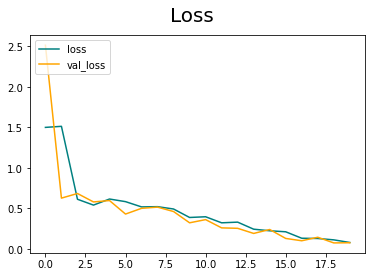

In [27]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

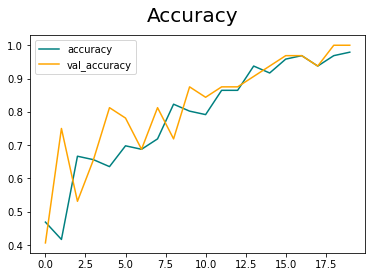

In [28]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [29]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [30]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

In [31]:
print(pre.result())
print(re.result())
print(acc.result())

tf.Tensor(1.0, shape=(), dtype=float32)
tf.Tensor(1.0, shape=(), dtype=float32)
tf.Tensor(1.0, shape=(), dtype=float32)


### *Testing the Model by Making Predictions*

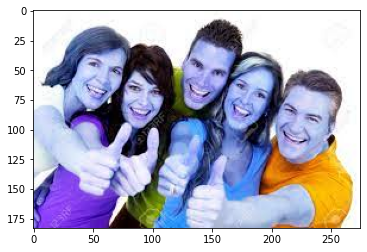

In [33]:
# Test Image
img = cv2.imread('C:/Users/KIIT/AK - MY FILES (ML)/4) Neural Networks Projects/Any Image Classifier (CNN)/Data/happy_people/image21.jpeg')
plt.imshow(img)
plt.show()

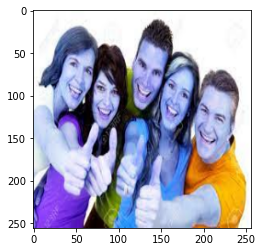

In [34]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [35]:
yhat = model.predict(np.expand_dims(resize/255, 0))

In [36]:
yhat

array([[0.0049285]], dtype=float32)

In [37]:
if yhat > 0.5: 
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

Predicted class is Happy


# Saving the Model

In [42]:
model.save(os.path.join('models','imageclassifier_1.h5'))

In [43]:
new_model = load_model('models/imageclassifier.h5')

In [44]:
new_model.predict(np.expand_dims(resize/255, 0))

array([[0.0049285]], dtype=float32)